<a href="https://colab.research.google.com/github/imkhubaibraza/msds19064_Project_DLSpring2020/blob/master/DlSelfEnsembleMeanTeacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import and Install libraries

In [ ]:
# !pip install batchup

In [2]:
!pip install batchup

     |████████████████████████████████| 81kB 5.2MB/s 


In [3]:
# I changed
#FER2013
# Emotion labels in the dataset:
# 0: -4593 images- Angry
# 1: -6198 images- Neutral
# 2: -5121 images- Fear
# 3: -8989 images- Happy
# 4: -6077 images- Sad
# 5: -4002 images- Surprise
# 1: -547 images- Disgust

# "anger","fear", "happy", "surprise", "neutral"

#DRAMA
# 0: anger
# 1: neutral
# 2: fear
# 3: happy
# 4: sadness
# 5: surprise
# 6: disgust

In [4]:
import time
import math
import numpy as np
from batchup import data_source, work_pool
import torch, torch.cuda
from torch import nn
from torch.nn import functional as F
import glob
import numpy as np
from skimage.transform import downscale_local_mean, resize
from batchup.datasets import mnist, fashion_mnist, cifar10, svhn, stl, usps
import os
import sys
import time
import math
import numpy as np
from batchup import data_source, work_pool
import torch
import torch.nn as nn
from torch.nn import functional as F
from sklearn.decomposition import PCA
import cv2
import glob
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import numpy as np
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!mkdir data
!unzip '/content/drive/My Drive/images/PDTS_merged_AFS.zip' -d 'data/'

Archive:  /content/drive/My Drive/images/PDTS_merged_AFS.zip
   creating: data/Angry/
  inflating: data/Angry/109.jpg      
  inflating: data/Angry/110.jpg      
  inflating: data/Angry/111.jpg      
  inflating: data/Angry/113.jpg      
  inflating: data/Angry/114.jpg      
  inflating: data/Angry/115.jpg      
  inflating: data/Angry/116.jpg      
  inflating: data/Angry/117.jpg      
  inflating: data/Angry/118.jpg      
  inflating: data/Angry/119.jpg      
  inflating: data/Angry/12.jpg       
  inflating: data/Angry/120.jpg      
  inflating: data/Angry/121.jpg      
  inflating: data/Angry/122.jpg      
  inflating: data/Angry/123.jpg      
  inflating: data/Angry/124.jpg      
  inflating: data/Angry/125.jpg      
  inflating: data/Angry/140.jpg      
  inflating: data/Angry/141.jpg      
  inflating: data/Angry/143.jpg      
  inflating: data/Angry/145.jpg      
  inflating: data/Angry/147.jpg      
  inflating: data/Angry/149.jpg      
  inflating: data/Angry/15.jpg       
  

### Augmnetation

In [6]:
def intens_aug_options(intens_scale_range, intens_offset_range):
    intens_scale_range_lower = intens_scale_range_upper = None
    if intens_scale_range != '':
        if ':' not in intens_scale_range:
            print('Invalid intens_scale_range format; should be float:float')
            return
        l, _, h = intens_scale_range.partition(':')
        try:
            intens_scale_range_lower = float(l)
            intens_scale_range_upper = float(h)
        except ValueError:
            print('Invalid intens_scale_range format; should be float:float')
            return

    intens_offset_range_lower = intens_offset_range_upper = None
    if intens_offset_range != '':
        if ':' not in intens_offset_range:
            print('Invalid intens_offset_range format; should be float:float')
            return
        l, _, h = intens_offset_range.partition(':')
        try:
            intens_offset_range_lower = float(l)
            intens_offset_range_upper = float(h)
        except ValueError:
            print('Invalid intens_offset_range format; should be float:float')
            return
    return intens_scale_range_lower, intens_scale_range_upper, intens_offset_range_lower, intens_offset_range_upper

# ----------------------------------------------------------------------------

def centre_xf(xf, size):
    """
    Centre the transformations in `xf` around (0,0), where the current centre is assumed to be at the
    centre of an image of shape `size`
    :param xf: transformation matrices, (N,2,3) array
    :param size: image size
    :return: centred transformation matrices, (N,2,3) array
    """
    height, width = size

    # centre_to_zero moves the centre of the image to (0,0)
    centre_to_zero = np.zeros((1, 2, 3), dtype=np.float32)
    centre_to_zero[0, 0, 0] = centre_to_zero[0, 1, 1] = 1.0
    centre_to_zero[0, 0, 2] = -float(width) * 0.5
    centre_to_zero[0, 1, 2] = -float(height) * 0.5

    # centre_to_zero then xf
    xf_centred = cat_nx2x3(xf, centre_to_zero)

    # move (0,0) back to the centre
    xf_centred[:, 0, 2] += float(width) * 0.5
    xf_centred[:, 1, 2] += float(height) * 0.5

    return xf_centred



def cat_nx2x3(a, b):
    """
    Multiply the N 2x3 transformations stored in `a` with those in `b`
    :param a: transformation matrices, (N,2,3) array
    :param b: transformation matrices, (N,2,3) array
    :return: `a . b`
    """
    a2 = a[:, :, :2]
    b2 = b[:, :, :2]

    ax = a[:, :, 2:3]
    bx = b[:, :, 2:3]

    ab2 = np.matmul(a2, b2)
    abx = ax + np.matmul(a2, bx)
    return np.append(ab2, abx, axis=2)


def identity_xf(N):
    """
    Construct N identity 2x3 transformation matrices
    :return: array of shape (N, 2, 3)
    """
    xf = np.zeros((N, 2, 3), dtype=np.float32)
    xf[:, 0, 0] = xf[:, 1, 1] = 1.0
    return xf


def rotation_matrices(thetas):
    """
    Generate rotation matrices
    :param thetas: rotation angles in radians as a (N,) array
    :return: rotation matrices, (N,2,3) array
    """
    N = thetas.shape[0]
    rot_xf = np.zeros((N, 2, 3), dtype=np.float32)
    rot_xf[:, 0, 0] = rot_xf[:, 1, 1] = np.cos(thetas)
    rot_xf[:, 1, 0] = np.sin(thetas)
    rot_xf[:, 0, 1] = -np.sin(thetas)
    return rot_xf

class ImageAugmentation (object):
    def __init__(self, hflip, xlat_range, affine_std, rot_std=0.0,
                 intens_flip=False,
                 intens_scale_range_lower=None, intens_scale_range_upper=None,
                 intens_offset_range_lower=None, intens_offset_range_upper=None,
                 scale_x_range=None, scale_y_range=None, scale_u_range=None, gaussian_noise_std=0.0,
                 blur_range=None):
        self.hflip = hflip
        self.xlat_range = xlat_range
        self.affine_std = affine_std
        self.rot_std = rot_std
        self.intens_scale_range_lower = intens_scale_range_lower
        self.intens_scale_range_upper = intens_scale_range_upper
        self.intens_offset_range_lower = intens_offset_range_lower
        self.intens_offset_range_upper = intens_offset_range_upper
        self.intens_flip = intens_flip
        self.scale_x_range = scale_x_range
        self.scale_y_range = scale_y_range
        self.scale_u_range = scale_u_range
        self.gaussian_noise_std = gaussian_noise_std
        self.blur_range = blur_range


    def augment(self, X):
        X = X.copy()
        xf = identity_xf(len(X))

        if self.hflip:
            x_hflip = np.random.binomial(1, 0.5, size=(len(X),)) * 2 - 1
            xf[:, 0, 0] = x_hflip

        if self.scale_x_range is not None and self.scale_x_range[0] is not None:
            xf[:, 0, 0] *= np.random.uniform(low=self.scale_x_range[0], high=self.scale_x_range[1], size=(len(X),))
        if self.scale_y_range is not None and self.scale_y_range[0] is not None:
            xf[:, 1, 1] *= np.random.uniform(low=self.scale_y_range[0], high=self.scale_y_range[1], size=(len(X),))
        if self.scale_u_range is not None and self.scale_u_range[0] is not None:
            scale_u = np.random.uniform(low=self.scale_u_range[0], high=self.scale_u_range[1], size=(len(X),))
            xf[:, 0, 0] *= scale_u
            xf[:, 1, 1] *= scale_u

        if self.affine_std > 0.0:
            xf[:, :, :2] += np.random.normal(scale=self.affine_std, size=(len(X), 2, 2))

        if self.rot_std > 0.0:
            thetas = np.random.normal(scale=self.rot_std, size=(len(X),))
            rot_xf = rotation_matrices(thetas)
            xf = cat_nx2x3(xf, rot_xf)

        if self.xlat_range > 0.0:
            xf[:, :, 2:] += np.random.uniform(low=-self.xlat_range, high=self.xlat_range, size=(len(X), 2, 1))

        if self.intens_flip:
            col_factor = (np.random.binomial(1, 0.5, size=(len(X), 1, 1, 1)) * 2 - 1).astype(np.float32)
            X = (X * col_factor).astype(np.float32)

        if self.intens_scale_range_lower is not None:
            col_factor = np.random.uniform(low=self.intens_scale_range_lower, high=self.intens_scale_range_upper,
                                           size=(len(X), 1, 1, 1))

            X = (X * col_factor).astype(np.float32)

        if self.intens_offset_range_lower is not None:
            col_offset = np.random.uniform(low=self.intens_offset_range_lower, high=self.intens_offset_range_upper,
                                           size=(len(X), 1, 1, 1))

            X = (X + col_offset).astype(np.float32)

        xf_centred = centre_xf(xf, X.shape[2:])
        for i in range(len(X)):
            if X.shape[1] == 1:
                X[i, 0, :, :] = cv2.warpAffine(X[i, 0, :, :], xf_centred[i, :, :], (X.shape[3], X.shape[2]))
            else:
                X[i, :, :, :] = cv2.warpAffine(X[i, :, :, :].transpose(1,2,0), xf_centred[i, :, :], (X.shape[3], X.shape[2])).transpose(2,0,1)

        if self.blur_range is not None and self.blur_range[0] is not None:
            sigmas = np.random.uniform(low=self.blur_range[0], high=self.blur_range[1], size=(len(X),))
            sigmas = np.maximum(sigmas, 0.0)
            for i in range(len(X)):
                sigma = sigmas[i]
                # ksize must be odd number
                ksize = int(sigma+0.5) * 8 + 1
                if X.shape[1] == 1:
                    X[i, 0, :, :] = cv2.GaussianBlur(X[i, 0, :, :], (ksize, ksize), sigmaX=sigma)
                else:
                    X[i, :, :, :] = cv2.GaussianBlur(X[i, :, :, :].transpose(1,2,0), (ksize, ksize), sigmaX=sigma).transpose(2,0,1)

        if self.gaussian_noise_std > 0.0:
            X += np.random.normal(scale=self.gaussian_noise_std, size=X.shape).astype(np.float32)

        return X

    def augment_pair(self, X):
        return self.augment(X), self.augment(X)

### Loading Dataset Block

In [7]:
#class of Datset FER , Drama , CK
class Dataset():
    '''
    Loading Dataset Manually FER , DRAMA , CK
    '''

    def __init__(self, path, extension):
        if extension =="csv":
            x , y = self.load_fer2013(path , extension)
            train_x_s = x[:, :]
            train_y_s = y[:].astype(int)
            train_x_s = train_x_s.reshape((train_x_s.shape[0], 1 , 48, 48 ))
        else:
            train_x_s, train_y_s = self.load_CK_Drama_Dataset(path,extension=extension)
            train_x_s = train_x_s.reshape(train_x_s.shape[0], 1, train_x_s.shape[1], train_x_s.shape[2])

        self.train_X = train_x_s.astype(np.float32)
        self.val_X = train_x_s.astype(np.float32)
        self.test_X = train_x_s.astype(np.float32)
        self.train_y = train_y_s
        self.val_y = train_y_s
        self.test_y = train_y_s



    def load_CK_Drama_Dataset(self,path, extension="png"):
        '''
        CK+ and Drama Dataset
        '''

        print('Loading Dataset...')
        
        train_x, train_y, test_x, test_y = [], [], [], []
        expressions = ["Angry","Neutral" , "Fear", "Happy", "Sad" , "Surprise",  "Disgust"]

        for i in range(len(expressions)):
            print(expressions[i])
            if (( i== 6) or (i== 5) ):
                continue
            for filename in glob.glob(path + expressions[i]+'/*.' + extension):
                im= resize(plt.imread(filename), (48, 48)) 
                train_x.append(im)
                train_y.append(i)
        return np.array(train_x), np.array(train_y)

    def load_fer2013(self , path , extention):
        '''
        FER2013 Dataset
        '''
        # x['emotion'] = x['female'].map({'female': 1, 'male': 0})
        x = pd.read_csv(path)
        x['emotion'] = x['emotion'].map({1:6 ,0:0 , 2:2 , 3 :3 , 4:4,5:5 , 6:1 })

        print(x.head())
        data = x.values
        data = data[(data[: , 0] != 6)]
        data = data[(data[: , 0] != 5)]
            
        y = data[:, 0]
        pixels = data[:, 1]
        X = np.zeros((pixels.shape[0], 48*48))
        for ix in range(X.shape[0]):
            p = pixels[ix].split(' ')
            for iy in range(X.shape[1]):
                X[ix, iy] = int(p[iy])
        x = X   
        x = x / 255 # comment by khubaib

        return x ,y

def load_dataset(name, invert=False, zero_centre=False, intensity_scale=1.0, val=False, pad32=False, downscale_x=1, rgb=False):
    print('Loading ', name ,' Dataset...')

    if name == "CK":
        d = Dataset("/content/drive/My Drive/images/CK/", "png" )
    elif name == "DRAMA":
        d = Dataset("/content/drive/My Drive/images/Drama/", extension="jpg")
    elif name == "FER2013":
        d = Dataset("/content/drive/My Drive/images/fer2013.csv", extension = "csv")
    elif name == "PFED":
        d = Dataset("/content/drive/My Drive/images/PFED/", extension="jpg")
    elif name == "PFED_Merged_AFS":
        d = Dataset("/content/data/", extension="jpg")
    else:
        print("Error Dataset not loaded")


    d.train_X, d.val_X, d.train_y, d.val_y = train_test_split(d.train_X, d.train_y, test_size=0.2)
    d.val_X, d.test_X, d.val_y, d.test_y = train_test_split(d.val_X, d.val_y, test_size=0.5)
    #paste here

    if downscale_x != 1:
        d.train_X = downscale_local_mean(d.train_X, (1, 1, 1, downscale_x))
        d.val_X = downscale_local_mean(d.val_X, (1, 1, 1, downscale_x))
        d.test_X = downscale_local_mean(d.test_X, (1, 1, 1, downscale_x))

    if pad32:
        py = (32 - d.train_X.shape[2]) // 2
        px = (32 - d.train_X.shape[3]) // 2
        # Pad 28x28 to 32x32
        d.train_X = np.pad(d.train_X, [(0 ,0), (0 ,0), (py ,py), (px ,px)], mode='constant')
        d.val_X = np.pad(d.val_X, [(0 ,0), (0 ,0), (py ,py), (px ,px)], mode='constant')
        d.test_X = np.pad(d.test_X, [(0 ,0), (0 ,0), (py ,py), (px ,px)], mode='constant')

    if invert:
        # Invert
        d.train_X = 1.0 - d.train_X
        d.val_X = 1.0 - d.val_X
        d.test_X = 1.0 - d.test_X

    if intensity_scale != 1.0:
        d.train_X = (d.train_X - 0.5) * intensity_scale + 0.5
        d.val_X = (d.val_X - 0.5) * intensity_scale + 0.5
        d.test_X = (d.test_X - 0.5) * intensity_scale + 0.5

    if zero_centre:
        d.train_X = d.train_X * 2.0 - 1.0
        d.test_X = d.test_X * 2.0 - 1.0

    if rgb:
        d.train_X = np.concatenate([d.train_X] * 3, axis=1)
        d.val_X = np.concatenate([d.val_X] * 3, axis=1)
        d.test_X = np.concatenate([d.test_X] * 3, axis=1)

    print('MNIST: train: X.shape={}, y.shape={}, val: X.shape={}, y.shape={}, test: X.shape={}, y.shape={}'.format(
            d.train_X.shape, d.train_y.shape,
            d.val_X.shape, d.val_y.shape,
            d.test_X.shape, d.test_y.shape))

    print('MNIST: train: X.min={}, X.max={}'.format(
        d.train_X.min(), d.train_X.max()))

    d.n_classes = 5
    return d

In [8]:
#standrization of data subtract mean and divide with standard deviation
def standardise_samples(X):
  X = X - X.mean(axis=(1,2,3), keepdims=True)
  X = X / (X.std(axis=(1,2,3), keepdims=True)+0.0000001) # add small value so that it will not give nan value
  return X

def standardise_dataset(ds):
  ds.train_X_orig = ds.train_X[...].copy()
  ds.val_X_orig = ds.val_X[...].copy()
  ds.test_X_orig = ds.test_X[...].copy()
  ds.train_X = standardise_samples(ds.train_X[...])
  ds.val_X = standardise_samples(ds.val_X[...])
  ds.test_X = standardise_samples(ds.test_X[...])

### Loss Functions

In [9]:

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.35, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [10]:


def focal_loss_bal(inputs, targets , alpha = 2  , gamma = 0.5):
    BCE_loss = F.cross_entropy(inputs, targets)
    pt = torch.exp(-BCE_loss)
    F_loss = alpha * (1-pt)**gamma * BCE_loss
    return F_loss


def robust_binary_crossentropy(pred, tgt):
  inv_tgt = -tgt + 1.0
  inv_pred = -pred + 1.0 + 1e-6
  return -(tgt * torch.log(pred + 1.0e-6) + inv_tgt * torch.log(inv_pred))

def bugged_cls_bal_bce(pred, tgt):
  inv_tgt = -tgt + 1.0
  inv_pred = pred + 1.0 + 1e-6
  return -(tgt * torch.log(pred + 1.0e-6) + inv_tgt * torch.log(inv_pred))

def log_cls_bal(pred, tgt):
  return -torch.log(pred + 1.0e-6)

def get_cls_bal_function(name):
    if name == 'bce':
        return robust_binary_crossentropy
    elif name == 'log':
        return log_cls_bal
    elif name == 'bug':
        return bugged_cls_bal_bce
    elif name =='focal':
        return FocalLoss
    

### Architecture

In [11]:
#Architecture
class Grey_32_64_128_gp (nn.Module):
  def __init__(self, n_classes):
    super(Grey_32_64_128_gp, self).__init__()
# n_channels, out_channels, kernel_size, stride=1, padding=0,\
#  dilation=1, groups=1, bias=True, padding_mode='zeros'
    self.conv1_1 = nn.Conv2d(1, 32, (3, 3), padding=1)
    self.conv1_1_bn = nn.BatchNorm2d(32)
    self.conv1_2 = nn.Conv2d(32, 32, (3, 3), padding=1)
    self.conv1_2_bn = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d((2, 2))

    self.conv2_1 = nn.Conv2d(32, 64, (3, 3), padding=1)
    self.conv2_1_bn = nn.BatchNorm2d(64)
    self.conv2_2 = nn.Conv2d(64, 64, (3, 3), padding=1)
    self.conv2_2_bn = nn.BatchNorm2d(64)
    self.conv2_3 = nn.Conv2d(64, 64, (3, 3), padding=1)
    self.conv2_3_bn = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d((2, 2))

    self.conv3_1 = nn.Conv2d(64, 128, (3, 3), padding=1)
    self.conv3_1_bn = nn.BatchNorm2d(128)
    self.conv3_2 = nn.Conv2d(128, 128, (3, 3), padding=1)
    self.conv3_2_bn = nn.BatchNorm2d(128)
    self.conv3_3 = nn.Conv2d(128, 128, (3, 3), padding=1)
    self.conv3_3_bn = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d((2, 2))

    self.drop1 = nn.Dropout()

    self.fc4 = nn.Linear(128, 128)
    self.fc5 = nn.Linear(128, n_classes)

  def forward(self, x):
    x = F.relu(self.conv1_1_bn(self.conv1_1(x)))
    x = self.pool1(F.relu(self.conv1_2_bn(self.conv1_2(x))))

    x = F.relu(self.conv2_1_bn(self.conv2_1(x)))
    x = F.relu(self.conv2_2_bn(self.conv2_2(x)))
    x = self.pool2(F.relu(self.conv2_3_bn(self.conv2_3(x))))

    x = F.relu(self.conv3_1_bn(self.conv3_1(x)))
    x = F.relu(self.conv3_2_bn(self.conv3_2(x)))
    x = self.pool3(F.relu(self.conv3_3_bn(self.conv3_3(x))))

    x = F.avg_pool2d(x, 4)
    x = x.view(-1, 128)
    x = self.drop1(x)

    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

class OldWeightEMA (object):
    """
    Exponential moving average weight optimizer for mean teacher model
    """
    def __init__(self, target_net, source_net, alpha=0.999):
        self.target_params = list(target_net.parameters())
        self.source_params = list(source_net.parameters())
        self.alpha = alpha

        for p, src_p in zip(self.target_params, self.source_params):
            p.data[:] = src_p.data[:]

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for p, src_p in zip(self.target_params, self.source_params):
            p.data.mul_(self.alpha)
            p.data.add_(src_p.data * one_minus_alpha)


class EMAWeightOptimizer (object):
    def __init__(self, target_net, source_net, alpha=0.999):
        self.target_net = target_net
        self.source_net = source_net
        self.ema_alpha = alpha
        self.target_params = list(target_net.state_dict().values())
        self.source_params = list(source_net.state_dict().values())

        for tgt_p, src_p in zip(self.target_params, self.source_params):
            tgt_p[:] = src_p[:]

        target_keys = set(target_net.state_dict().keys())
        source_keys = set(source_net.state_dict().keys())
        if target_keys != source_keys:
            raise ValueError('Source and target networks do not have the same state dict keys; do they have different architectures?')

    def step(self):
        one_minus_alpha = 1.0 - self.ema_alpha
        for tgt_p, src_p in zip(self.target_params, self.source_params):
            tgt_p.mul_(self.ema_alpha)
            tgt_p.add_(src_p * one_minus_alpha)

In [12]:
def compute_aug_loss(stu_out, tea_out):
        # Augmentation loss
        # if use_rampup:
        #     unsup_mask = None
        #     conf_mask_count = None
        #     unsup_mask_count = None
        # else:
        conf_tea = torch.max(tea_out, 1)[0]
        unsup_mask = conf_mask = (conf_tea > confidence_thresh).float()
        unsup_mask_count = conf_mask_count = conf_mask.sum()

        if loss == 'bce':
            aug_loss = robust_binary_crossentropy(stu_out, tea_out)
        else:
            d_aug_loss = stu_out - tea_out
            aug_loss = d_aug_loss * d_aug_loss

        # # Class balance scaling
        # if cls_bal_scale:
        #     if use_rampup:
        #         n_samples = float(aug_loss.shape[0])
        #     else:
        #         n_samples = unsup_mask.sum()
        #     avg_pred = n_samples / float(n_classes)
        #     bal_scale = avg_pred / torch.clamp(tea_out.sum(dim=0), min=1.0)
        #     if cls_bal_scale_range != 0.0:
        #         bal_scale = torch.clamp(bal_scale, min=1.0/cls_bal_scale_range, max=cls_bal_scale_range)
        #     bal_scale = bal_scale.detach()
        #     aug_loss = aug_loss * bal_scale[None, :]


        aug_loss = aug_loss.mean(dim=1)
        unsup_loss = (aug_loss * unsup_mask).mean()

        # Class balance loss
        if cls_balance > 0.0:
            # Compute per-sample average predicated probability
            # Average over samples to get average class prediction
            avg_cls_prob = stu_out.mean(dim=0)
            # Compute loss
            equalise_cls_loss = cls_bal_fn(avg_cls_prob, float(1.0 / n_classes))

            equalise_cls_loss = equalise_cls_loss.mean() * n_classes

            if use_rampup:
                equalise_cls_loss = equalise_cls_loss * rampup_weight_in_list[0]
            else:
                if rampup == 0:
                    equalise_cls_loss = equalise_cls_loss * unsup_mask.mean(dim=0)

            unsup_loss += equalise_cls_loss * cls_balance

        return unsup_loss, conf_mask_count, unsup_mask_count

### Model predictions

In [13]:
def f_pred_src(X_sup):
  X_var = torch.tensor(X_sup, dtype=torch.float, device=torch_device)
  student_net.eval()
  teacher_net.eval()
  return (F.softmax(student_net(X_var), dim=1).detach().cpu().numpy(),
          F.softmax(teacher_net(X_var), dim=1).detach().cpu().numpy())

def f_pred_tgt(X_sup):
  X_var = torch.tensor(X_sup, dtype=torch.float, device=torch_device)
  student_net.eval()
  teacher_net.eval()
  return (F.softmax(student_net(X_var), dim=1).detach().cpu().numpy(),
          F.softmax(teacher_net(X_var), dim=1).detach().cpu().numpy())

def f_eval_src(X_sup, y_sup):
  y_pred_prob_stu, y_pred_prob_tea = f_pred_src(X_sup)
  y_pred_stu = np.argmax(y_pred_prob_stu, axis=1)
  y_pred_tea = np.argmax(y_pred_prob_tea, axis=1)
  return (float((y_pred_stu != y_sup).sum()), float((y_pred_tea != y_sup).sum()))

def f_eval_tgt(X_sup, y_sup):
  y_pred_prob_stu, y_pred_prob_tea = f_pred_tgt(X_sup)
  y_pred_stu = np.argmax(y_pred_prob_stu, axis=1)
  y_pred_tea = np.argmax(y_pred_prob_tea, axis=1)
  return (float((y_pred_stu != y_sup).sum()), float((y_pred_tea != y_sup).sum()))

print('Compiled evaluation function')

Compiled evaluation function


### Loading Dataset

In [14]:
# Subaib Dataset
# Angry 90
# Fear 122
# Happy 950
# Neutral 1300
# Sad 309
# Surprise 339
# Total 3110

# Our Dataset
# Angry 129
# Fear 85
# Happy 276
# Neutral 291
# Sad 332
# Surprise 106
# Total 1142

In [15]:
# FER2013 CK DRAMA  
d_source_o = load_dataset(name="FER2013", invert=False, zero_centre=False, pad32=False, val=False)
d_target_o = load_dataset(name="PFED_Merged_AFS", invert=False, zero_centre=False, pad32=False, val=False)
# d_testing_o_final = load_dataset(name="PFED", invert=False, zero_centre=False, pad32=False, val=False)
# d_target_o1 = load_dataset(name="PFED_Merged_AFS", invert=False, zero_centre=False, pad32=False, val=False)
# d_target_o = load_dataset(name="DRAMA", invert=False, zero_centre=False, pad32=False, val=False)

Loading  FER2013  Dataset...
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        1  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
MNIST: train: X.shape=(25070, 1, 48, 48), y.shape=(25070,), val: X.shape=(3134, 1, 48, 48), y.shape=(3134,), test: X.shape=(3134, 1, 48, 48), y.shape=(3134,)
MNIST: train: X.min=0.0, X.max=1.0
Loading  PFED_Merged_AFS  Dataset...
Loading Dataset...
Angry
Neutral
Fear
Happy
Sad
Surprise
Disgust
MNIST: train: X.shape=(2653, 1, 48, 48), y.shape=(2653,), val: X.shape=(332, 1, 48, 48), y.shape=(332,), test: X.shape=(332, 1, 48, 48), y.shape=(332,)
MNIST: train: X.min=0.0, X.max=1.0


In [16]:
d_source_o.train_X.shape

(25070, 1, 48, 48)

In [45]:
d_source = d_source_o
d_target = d_target_o
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
src_intens_scale_range = ''
src_intens_offset_range = ''
tgt_intens_scale_range = ''
tgt_intens_offset_range = ''

src_intens_scale_range_lower, src_intens_scale_range_upper, src_intens_offset_range_lower, src_intens_offset_range_upper = intens_aug_options(src_intens_scale_range, src_intens_offset_range)
tgt_intens_scale_range_lower, tgt_intens_scale_range_upper, tgt_intens_offset_range_lower, tgt_intens_offset_range_upper = intens_aug_options(tgt_intens_scale_range, tgt_intens_offset_range)

n_chn = 0

src_hflip =  False
src_xlat_range = 2.0
src_affine_std = 0.1
src_intens_flip = False
src_gaussian_noise_std = 0.1
tgt_hflip = False
tgt_xlat_range = 2.0
tgt_affine_std =  0.1
tgt_intens_flip = False
tgt_gaussian_noise_std = 0.1
standardise_dataset(d_source)
standardise_dataset(d_target)

In [94]:
# del d_target.train_y
n_classes = d_source.n_classes
print('Loaded data')

# arch = 'grey-32-64-128-gp'
expected_shape = (1, 48, 48)

if expected_shape != d_source.train_X.shape[1:]:
    print('Architecture {} not compatible with experiment {}; it needs samples of shape {}, data has samples of shape {}'.format(arch, exp, expected_shape, d_source.train_X.shape[1:]))

learning_rate = 0.000001
net_class = Grey_32_64_128_gp
student_net = net_class(n_classes).to(torch_device)
teacher_net = net_class(n_classes).to(torch_device)
student_params = list(student_net.parameters())
teacher_params = list(teacher_net.parameters())
for param in teacher_params:
    param.requires_grad = False

student_optimizer = torch.optim.Adam(student_params , lr = learning_rate)

# decayRate = 0.96
# my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=student_optimizer, gamma=decayRate)

fix_ema = False
teacher_alpha = 0.99

if fix_ema:
    teacher_optimizer = EMAWeightOptimizer(teacher_net, student_net, alpha=teacher_alpha)
else:
    teacher_optimizer = OldWeightEMA(teacher_net, student_net, alpha=teacher_alpha)
# here we add this line cross entropy change to FocalLoss()
classification_criterion = nn.CrossEntropyLoss() 
print('Built network')

Loaded data
Built network


In [95]:
src_aug = ImageAugmentation(
    src_hflip, src_xlat_range, src_affine_std,
    intens_flip=src_intens_flip,
    intens_scale_range_lower=src_intens_scale_range_lower, intens_scale_range_upper=src_intens_scale_range_upper,
    intens_offset_range_lower=src_intens_offset_range_lower,
    intens_offset_range_upper=src_intens_offset_range_upper,
    gaussian_noise_std=src_gaussian_noise_std
)
tgt_aug = ImageAugmentation(
    tgt_hflip, tgt_xlat_range, tgt_affine_std,
    intens_flip=tgt_intens_flip,
    intens_scale_range_lower=tgt_intens_scale_range_lower, intens_scale_range_upper=tgt_intens_scale_range_upper,
    intens_offset_range_lower=tgt_intens_offset_range_lower,
    intens_offset_range_upper=tgt_intens_offset_range_upper,
    gaussian_noise_std=tgt_gaussian_noise_std
)

In [96]:
combine_batches = False
if combine_batches:
  def augment(X_sup, y_src, X_tgt):
      X_src_stu, X_src_tea = src_aug.augment_pair(X_sup)
      X_tgt_stu, X_tgt_tea = tgt_aug.augment_pair(X_tgt)
      return X_src_stu, X_src_tea, y_src, X_tgt_stu, X_tgt_tea
else:
  def augment(X_src, y_src, X_tgt):
      X_src = src_aug.augment(X_src)
      X_tgt_stu, X_tgt_tea = tgt_aug.augment_pair(X_tgt)
      return X_src, y_src, X_tgt_stu, X_tgt_tea

In [97]:
rampup_weight_in_list = [0]

In [98]:
cls_balance_loss = 'bce'
cls_bal_fn = get_cls_bal_function(cls_balance_loss)
cls_bal_scale = False
cls_balance = 0.005

In [99]:
if combine_batches:
    def f_train(X_src0, X_src1, y_src, X_tgt0, X_tgt1):
        X_src0 = torch.tensor(X_src0, dtype=torch.float, device=torch_device)
        X_src1 = torch.tensor(X_src1, dtype=torch.float, device=torch_device)
        y_src = torch.tensor(y_src, dtype=torch.long, device=torch_device)
        X_tgt0 = torch.tensor(X_tgt0, dtype=torch.float, device=torch_device)
        X_tgt1 = torch.tensor(X_tgt1, dtype=torch.float, device=torch_device)

        n_samples = X_src0.size()[0]
        n_total = n_samples + X_tgt0.size()[0]

        student_optimizer.zero_grad()
        student_net.train()
        teacher_net.train()

        # Concatenate source and target mini-batches
        X0 = torch.cat([X_src0, X_tgt0], 0)
        X1 = torch.cat([X_src1, X_tgt1], 0)

        student_logits_out = student_net(X0)
        student_prob_out = F.softmax(student_logits_out, dim=1)

        src_logits_out = student_logits_out[:n_samples]
        src_prob_out = student_prob_out[:n_samples]

        teacher_logits_out = teacher_net(X1)
        teacher_prob_out = F.softmax(teacher_logits_out, dim=1)

        # Supervised classification loss
        if double_softmax:
            clf_loss = classification_criterion(src_prob_out, y_src)
        else:
            clf_loss = classification_criterion(src_logits_out, y_src)

        unsup_loss, conf_mask_count, unsup_mask_count = compute_aug_loss(student_prob_out, teacher_prob_out)

        loss_expr = clf_loss + unsup_loss * unsup_weight

        loss_expr.backward()
        student_optimizer.step()
        teacher_optimizer.step()

        outputs = [float(clf_loss) * n_samples, float(unsup_loss) * n_total]
        if not use_rampup:
            mask_count = float(conf_mask_count) * 0.5
            unsup_count = float(unsup_mask_count) * 0.5

            outputs.append(mask_count)
            outputs.append(unsup_count)
        return tuple(outputs)
else:
    def f_train(X_src, y_src, X_tgt0, X_tgt1):
        X_src = torch.tensor(X_src, dtype=torch.float, device=torch_device)
        y_src = torch.tensor(y_src, dtype=torch.long, device=torch_device)
        X_tgt0 = torch.tensor(X_tgt0, dtype=torch.float, device=torch_device)
        X_tgt1 = torch.tensor(X_tgt1, dtype=torch.float, device=torch_device)

        student_optimizer.zero_grad()
        student_net.train()
        teacher_net.train()

        src_logits_out = student_net(X_src)
        student_tgt_logits_out = student_net(X_tgt0)
        student_tgt_prob_out = F.softmax(student_tgt_logits_out, dim=1)
        teacher_tgt_logits_out = teacher_net(X_tgt1)
        teacher_tgt_prob_out = F.softmax(teacher_tgt_logits_out, dim=1)

        # Supervised classification loss
        if double_softmax:
            clf_loss = classification_criterion(F.softmax(src_logits_out, dim=1), y_src)
        else:
            clf_loss = classification_criterion(src_logits_out, y_src)

        unsup_loss, conf_mask_count, unsup_mask_count = compute_aug_loss(student_tgt_prob_out, teacher_tgt_prob_out)

        loss_expr = clf_loss + unsup_loss * unsup_weight

        loss_expr.backward()
        student_optimizer.step()
        teacher_optimizer.step()

        n_samples = X_src.size()[0]

        outputs = [float(clf_loss) * n_samples, float(unsup_loss) * n_samples]
        if not use_rampup:
            mask_count = float(conf_mask_count)
            unsup_count = float(unsup_mask_count)

            outputs.append(mask_count)
            outputs.append(unsup_count)
        return tuple(outputs)

print('Compiled training function')

Compiled training function


In [100]:
print('Training...')
sup_ds = data_source.ArrayDataSource([d_source.train_X, d_source.train_y], repeats=-1)
tgt_train_ds = data_source.ArrayDataSource([d_target.train_X], repeats=-1)
train_ds = data_source.CompositeDataSource([sup_ds, tgt_train_ds]).map(augment)
# train_ds = pool.parallel_data_source(train_ds)

epoch_size = "target"
batch_size = 32

if epoch_size == 'target':
  n_samples = d_target.train_X.shape[0]
  
n_train_batches = n_samples // batch_size

source_test_ds = data_source.ArrayDataSource([d_source.test_X, d_source.test_y])
target_test_ds = data_source.ArrayDataSource([d_target.test_X, d_target.test_y])


seed = 0
if seed != 0:
  shuffle_rng = np.random.RandomState(seed)
else:
  shuffle_rng = np.random

train_batch_iter = train_ds.batch_iterator(batch_size=batch_size, shuffle=shuffle_rng)
best_teacher_model_state = {k: v.cpu().numpy() for k, v in teacher_net.state_dict().items()}

Training...


In [101]:
def accuracy_define(testX , testY , network , batch_size = 1):
    network.to('cpu')
    correct = 0
    predict_list = []
    for i in range(int(testX.shape[0]/batch_size)):
        out = network(torch.Tensor(testX[i* batch_size: i*batch_size+batch_size]))
        _, predicted = torch.max(out, 1)

        predict_list.append(predicted)
        c = (predicted == testY[i* batch_size: i*batch_size+batch_size])
        correct += int(c.sum())
    accuracy = correct/testX.shape[0] *100
    return predict_list , accuracy

### Loading saved model

In [102]:
train_loss_list = []
tgt_teacher_list_error_per = []

In [55]:
def load_model(name): # cv_Fer2013
    student_net.load_state_dict(torch.load( '/content/drive/My Drive/images/model/'+name+'_studentModelpoint001.pth'))
    teacher_net.load_state_dict(torch.load( '/content/drive/My Drive/images/model/'+name+'_studentModelpoint001.pth')) 
    loss = torch.load( '/content/drive/My Drive/images/model/'+name+'loss_studentModelpoint001.pth')
    acc = torch.load('/content/drive/My Drive/images/model/'+name+'acc_studentModelpoint001.pth')
    return loss , acc

In [103]:
train_loss_list , tgt_teacher_list_error_per =  load_model('5classs/final_PDTS_Fer2013')

In [75]:
len(train_loss_list)

27

### Start Training

In [ ]:
# train_loss_list

In [104]:
rampup = 0
use_rampup = rampup > 0
double_softmax = False
confidence_thresh = 0.96837722
loss = "focal"
unsup_weight = 3

In [110]:
student_net.to(torch_device)
teacher_net.to(torch_device)

num_epochs = 10
best_conf_mask_rate = 0.0
best_src_test_err = 1.0

for epoch in range(num_epochs):
  t1 = time.time()
  if use_rampup:
      if epoch < rampup:
          p = max(0.0, float(epoch)) / float(rampup)
          p = 1.0 - p
          rampup_value = math.exp(-p * p * 5.0)
      else:
          rampup_value = 1.0

      rampup_weight_in_list[0] = rampup_value

  train_res = data_source.batch_map_mean(f_train, train_batch_iter, n_batches=n_train_batches)

  train_clf_loss = train_res[0]
  train_loss_list.append(train_clf_loss)

  if combine_batches:
      unsup_loss_string = 'unsup (both) loss={:.6f}'.format(train_res[1])
  else:
      unsup_loss_string = 'unsup (tgt) loss={:.6f}'.format(train_res[1])

  src_test_err_stu, src_test_err_tea = source_test_ds.batch_map_mean(f_eval_src, batch_size=batch_size * 2)
  tgt_test_err_stu, tgt_test_err_tea = target_test_ds.batch_map_mean(f_eval_tgt, batch_size=batch_size * 2)
  tgt_teacher_list_error_per.append(tgt_test_err_tea)

  if use_rampup:
    unsup_loss_string = '{}, rampup={:.3%}'.format(unsup_loss_string, rampup_value)
    if src_test_err_stu < best_src_test_err:
        best_src_test_err = src_test_err_stu
        best_teacher_model_state = {k: v.cpu().numpy() for k, v in teacher_net.state_dict().items()}
        improve = '*** '
    else:
        improve = ''
  else:
    conf_mask_rate = train_res[-2]
    unsup_mask_rate = train_res[-1]
    if conf_mask_rate > best_conf_mask_rate:
      best_conf_mask_rate = conf_mask_rate
      improve = '*** '
      best_teacher_model_state = {k: v.cpu().numpy() for k, v in teacher_net.state_dict().items()}
    else:
      improve = ''
    unsup_loss_string = '{}, conf mask={:.3%}, unsup mask={:.3%}'.format(
        unsup_loss_string, conf_mask_rate, unsup_mask_rate)

  t2 = time.time()
  print('{}Epoch {} took {:.2f}s: TRAIN clf loss={:.6f}, {}; '
            'SRC TEST ERR={:.3%}, TGT TEST student err={:.3%}, TGT TEST teacher err={:.3%}'.format(
            improve, epoch, t2 - t1, train_clf_loss, unsup_loss_string, src_test_err_stu, tgt_test_err_stu, tgt_test_err_tea))

*** Epoch 0 took 3.62s: TRAIN clf loss=0.732568, unsup (tgt) loss=0.002666, conf mask=16.502%, unsup mask=16.502%; SRC TEST ERR=35.482%, TGT TEST student err=45.783%, TGT TEST teacher err=44.277%
Epoch 1 took 3.52s: TRAIN clf loss=0.713492, unsup (tgt) loss=0.002546, conf mask=15.206%, unsup mask=15.206%; SRC TEST ERR=35.482%, TGT TEST student err=44.578%, TGT TEST teacher err=45.783%
Epoch 2 took 3.53s: TRAIN clf loss=0.744918, unsup (tgt) loss=0.002317, conf mask=16.120%, unsup mask=16.120%; SRC TEST ERR=35.386%, TGT TEST student err=45.181%, TGT TEST teacher err=45.181%
Epoch 3 took 3.53s: TRAIN clf loss=0.754039, unsup (tgt) loss=0.002465, conf mask=16.197%, unsup mask=16.197%; SRC TEST ERR=35.482%, TGT TEST student err=44.277%, TGT TEST teacher err=44.277%
Epoch 4 took 3.55s: TRAIN clf loss=0.757801, unsup (tgt) loss=0.002285, conf mask=15.358%, unsup mask=15.358%; SRC TEST ERR=35.514%, TGT TEST student err=44.277%, TGT TEST teacher err=44.277%
Epoch 5 took 3.58s: TRAIN clf loss=0

### Matrices for Model Evaluations

In [115]:
def train_valid_loss_curve(total_train_loss):
    plt.plot(total_train_loss)
    # plt.plot(total_valid_loss)
    plt.legend(['Training Loss','Validation Loss'])
    # plt.title('Loss Curve over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.show()

#plot accuracies curves using train history or test history

def train_valid_accuracy_curve(accuracy_train_history ):

    plt.title('Accuracy of Model')
    plt.plot(accuracy_train_history, label='train')
    # plt.plot(accuracy_valid_history, label='Validate')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def printConfusion_Matrix(c , classes_info , title):
  plt.pause(0.01)
  plt.figure()
  ax= plt.subplot()
  sns.heatmap(c, annot=True, ax = ax  ,cmap='Greens' ,fmt='g');

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title(title); 
  ax.xaxis.set_ticklabels(classes_info); ax.yaxis.set_ticklabels(classes_info);

In [108]:
classes_info

In [111]:
testX = torch.tensor(d_target_o.train_X)
testY = torch.tensor(d_target_o.train_y)
predict_list , accuracy = accuracy_define( testX , testY , teacher_net)
accuracy

57.29362985299661

In [86]:
# train_loss_list.append(0.93[:-1])

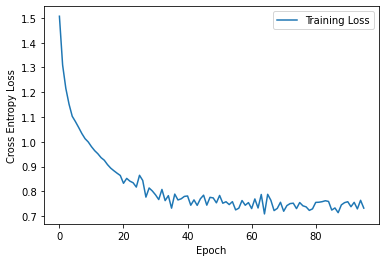

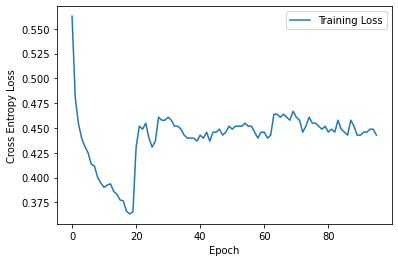

In [112]:
train_valid_loss_curve(train_loss_list[:])
train_valid_loss_curve(tgt_teacher_list_error_per)

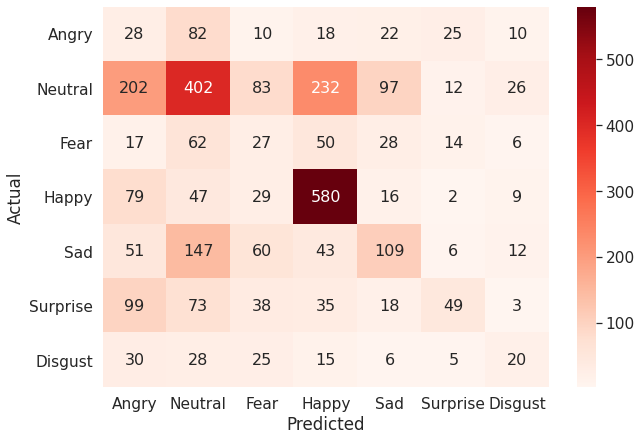

In [6]:
data = confusion_matrix(testY, predict_list)
expressions = ["Angry","Neutral" , "Fear", "Happy", "Sad" , "Surprise",  "Disgust"]
df_cm = pd.DataFrame(data, columns=expressions[:7], index = expressions[:7])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
# c, annot=True, ax = ax  ,cmap='Greens' ,
sn.heatmap(df_cm, annot=True, cmap='Reds' ,annot_kws={"size": 16}, fmt='g')# font size

##Perform Experiments on 5 classes

In [31]:
def model_saved(name): # cv_Fer2013
    torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/'+name+'_studentModelpoint001.pth')
    torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/'+name+'_teacherModelpoint001.pth') 
    torch.save(train_loss_list , '/content/drive/My Drive/images/model/'+name+'loss_studentModelpoint001.pth')
    torch.save(tgt_teacher_list_error_per ,'/content/drive/My Drive/images/model/'+name+'acc_studentModelpoint001.pth') 

In [93]:
model_saved('5classs/final_PDTS_Fer2013')

In [ ]:
# torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/6abc_PFED_Drama_Fer2013_studentModelpoint001.pth')
# torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/6abc_PFED_Drama_Fer2013_teacherModelpoint001.pth')

'''
PFED:
Test Set: 59.5
train_Set : 63.3
'''

In [ ]:
#So far best Experiment
torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/6ab_PFED_Drama_Fer2013_studentModelpoint001.pth')
torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/6ab_PFED_Drama_Fer2013_teacherModelpoint001.pth') 

'''
Drama:
Test_set: 50
Train_Set : 52.35


PFED:
Test_set: 64.21
Train_set: 61.515912897822446


array([[ 64,  48,  16,  11,  17],
       [189, 647,  47, 184,  74],
       [ 13,  46,  25,   8,   5],
       [ 23,  43,   6, 667,   3],
       [ 39,  92,  34,  21,  66]])

       
    '''

In [ ]:
# Experiment try on Log
torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/6b_PFED_Drama_Fer2013_studentModelpoint001.pth')
torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/6b_PFED_Drama_Fer2013_teacherModelpoint001.pth')
'''

#Deleted This below experiment
Drama:
bothaccuracy: 54.5% 
not classifying correctly

PFED:
Train_Set_results : 62.3534338358459
Test_set : 61.53846153846154


OLD:
array([[ 55,  54,  21,  12,  14],
       [183, 627,  65, 196,  70],
       [ 12,  34,  42,   5,   4],
       [ 25,  39,   8, 665,   5],
       [ 33,  82,  57,  22,  58]])
       


last_one
array([[ 51,  50,  17,  14,  18],
       [168, 615,  53, 230,  69],
       [ 16,  31,  36,   7,   5],
       [ 13,  30,   5, 718,   2],
       [ 33,  80,  37,  24,  66]])


array([[ 51,  53,  12,  18,  16],
       [156, 631,  42, 230,  76],
       [ 16,  41,  26,   5,   7],
       [ 11,  40,   4, 711,   2],
       [ 26,  93,  33,  24,  64]])
'''

'\n\nDrama:\nbothaccuracy: 54.5% \nnot classifying correctly\n\nPFED:\nTrain_Set_results : 62.3534338358459\nTest_set : 61.53846153846154\n\n\nOLD:\narray([[ 55,  54,  21,  12,  14],\n       [183, 627,  65, 196,  70],\n       [ 12,  34,  42,   5,   4],\n       [ 25,  39,   8, 665,   5],\n       [ 33,  82,  57,  22,  58]])\n       \nlast_one\narray([[ 51,  50,  17,  14,  18],\n       [168, 615,  53, 230,  69],\n       [ 16,  31,  36,   7,   5],\n       [ 13,  30,   5, 718,   2],\n       [ 33,  80,  37,  24,  66]])\n'

In [ ]:
# 0: anger
# 1: neutral
# 2: fear
# 3: happy
# 4: sadness
# 5: surprise
# 6: disgust

In [ ]:
# #6th experiment about pretraiend used 5-Drama_Fer2013
# # and target is PFED 
# torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/6_PFED_Drama_Fer2013_studentModelpoint001.pth')
# torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/6_PFED_Drama_Fer2013_teacherModelpoint001.pth') 
# '''
# Drama :
# getting 44 accuracy on both 

# PFED:
# Trainset accuaracy : 57.78894472361809
# TestSet Accuracy : 61
# Not well classified Anger

# with
# array([[ 40,  65,  21,   6,  24],
#        [150, 616,  91, 144, 140],
#        [ 11,  65,  11,   5,   5],
#        [ 23,  55,  23, 625,  16],
#        [ 35,  98,  31,  22,  66]])

# with log loss
# array([[ 39,  50,  36,  10,  21],
#        [108, 717, 115, 137,  64],
#        [  5,  44,  38,   6,   4],
#        [ 19,  67,  17, 633,   6],
#        [ 23, 102,  54,  21,  52]])
# PFED:
# train_set: 62
# test_set : 61.5

# '''


'\n2 Drama:\n52.36\n\n\narray([[ 61,  52,  16,  10,  17],\n       [176, 645,  40, 188,  92],\n       [ 11,  38,  32,   6,  10],\n       [ 19,  46,   7, 666,   4],\n       [ 34,  82,  36,  20,  80]])\n'

In [ ]:
# BAseline accuracy 10 on Train Drama and 11 on Test set

## Perform Experiment on 6 Classes

In [ ]:
#Fourth Experiment pretarined weights of PFED FER2013
torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/4-Drama_PFED_Fer2013_studentModelpoint001.pth')
torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/4-Drama_PFED_Fer2013_teacherModelpoint001.pth') 
'''
Drama
49 Test Set
46 Train Set
'''

In [ ]:
#Third as source domain PFED Data Set and using pretrained Fer2013 
# torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/3-PFED_Fer2013_studentModelpoint001.pth')
# torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/3-PFED_Fer2013_teacherModelpoint001.pth')

'''
PFED: 
Test set : 61.86%
Train_set : 59.73684210526316




array([[ 2,  9,  1,  1,  1,  0],
       [12, 93,  2, 23,  6,  1],
       [ 0,  5,  3,  2,  0,  0],
       [ 2,  9,  2, 92,  0,  0],
       [ 1, 14,  5,  3,  5,  2],
       [ 9, 12,  1,  4,  0, 11]])
'''




'\nPFED: \nTest set : 61.86%\nTrain_set : 59.73684210526316\n\n\n\n\narray([[ 2,  9,  1,  1,  1,  0],\n       [12, 93,  2, 23,  6,  1],\n       [ 0,  5,  3,  2,  0,  0],\n       [ 2,  9,  2, 92,  0,  0],\n       [ 1, 14,  5,  3,  5,  2],\n       [ 9, 12,  1,  4,  0, 11]])\n'

In [ ]:
# torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/2-fer_drama_studentModelpoint001.pth')
# torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/2-fer_drama_teacherModelpoint001.pth')

'''
*** Epoch 99 took 1.59s: TRAIN clf loss=1.050815, unsup (tgt) loss=0.003718,
 conf mask=8.438%, unsup mask=8.438%; SRC TEST ERR=40.889%, TGT TEST student err=58.197%, TGT TEST teacher err=54.918%

 PFED 
 Test Set Accuracy : 45.1
 Train Set accuracy: 49 

 PFED 
 Test Set Accuracy : 36.63%
 Train Set accuracy: 37%
'''

In [ ]:
# 0: anger
# 1: neutral
# 2: fear
# 3: happy
# 4: sadness
# 5: surprise
# 6: disgust

In [ ]:
#First Only Fer2013 Model
# torch.save(student_net.state_dict(), '/content/drive/My Drive/images/model/1-only_Fer2013_studentModelpoint001.pth')
# torch.save(teacher_net.state_dict(), '/content/drive/My Drive/images/model/1-only_Fer2013_teacherModelpoint001.pth')
'''
I trained on Fer2013 with 6 classes excluded disgust (imbalance example) target and source FER2013
params : 
Auto Adam
Final Error on this dataset in percentage round about 0.4

On Fer2013 after that as a test

Dramas accuracy: 
Test set is 25.4% 
Traing set is 20 %

PFED Dataset
PFED 22% Train
PFED 23 % TEst
'''

'\nI trained on Fer2013 with 6 classes excluded disgust (imbalance example)\nFinal Error on\n\n\n'

## Already Trained

In [ ]:
num_epochs = 500
best_conf_mask_rate = 0.0
best_src_test_err = 1.0
for epoch in range(num_epochs):
  t1 = time.time()
  if use_rampup:
      if epoch < rampup:
          p = max(0.0, float(epoch)) / float(rampup)
          p = 1.0 - p
          rampup_value = math.exp(-p * p * 5.0)
      else:
          rampup_value = 1.0

      rampup_weight_in_list[0] = rampup_value

  train_res = data_source.batch_map_mean(f_train, train_batch_iter, n_batches=n_train_batches)

  train_clf_loss = train_res[0]
  if combine_batches:
      unsup_loss_string = 'unsup (both) loss={:.6f}'.format(train_res[1])
  else:
      unsup_loss_string = 'unsup (tgt) loss={:.6f}'.format(train_res[1])

  src_test_err_stu, src_test_err_tea = source_test_ds.batch_map_mean(f_eval_src, batch_size=batch_size * 2)
  tgt_test_err_stu, tgt_test_err_tea = target_test_ds.batch_map_mean(f_eval_tgt, batch_size=batch_size * 2)


  if use_rampup:
    unsup_loss_string = '{}, rampup={:.3%}'.format(unsup_loss_string, rampup_value)
    if src_test_err_stu < best_src_test_err:
        best_src_test_err = src_test_err_stu
        best_teacher_model_state = {k: v.cpu().numpy() for k, v in teacher_net.state_dict().items()}
        improve = '*** '
    else:
        improve = ''
  else:
    conf_mask_rate = train_res[-2]
    unsup_mask_rate = train_res[-1]
    if conf_mask_rate > best_conf_mask_rate:
      best_conf_mask_rate = conf_mask_rate
      improve = '*** '
      best_teacher_model_state = {k: v.cpu().numpy() for k, v in teacher_net.state_dict().items()}
    else:
      improve = ''
    unsup_loss_string = '{}, conf mask={:.3%}, unsup mask={:.3%}'.format(
        unsup_loss_string, conf_mask_rate, unsup_mask_rate)


  t2 = time.time()
  print('{}Epoch {} took {:.2f}s: TRAIN clf loss={:.6f}, {}; '
            'SRC TEST ERR={:.3%}, TGT TEST student err={:.3%}, TGT TEST teacher err={:.3%}'.format(
            improve, epoch, t2 - t1, train_clf_loss, unsup_loss_string, src_test_err_stu, tgt_test_err_stu, tgt_test_err_tea))

*** Epoch 0 took 30.68s: TRAIN clf loss=1.034121, unsup (tgt) loss=0.002250, conf mask=4.032%, unsup mask=4.032%; SRC TEST ERR=36.069%, TGT TEST student err=51.083%, TGT TEST teacher err=51.644%
Epoch 1 took 30.71s: TRAIN clf loss=1.052567, unsup (tgt) loss=0.001982, conf mask=4.032%, unsup mask=4.032%; SRC TEST ERR=35.790%, TGT TEST student err=55.413%, TGT TEST teacher err=52.045%
*** Epoch 2 took 30.74s: TRAIN clf loss=1.027635, unsup (tgt) loss=0.002148, conf mask=4.194%, unsup mask=4.194%; SRC TEST ERR=36.417%, TGT TEST student err=53.168%, TGT TEST teacher err=52.125%
*** Epoch 3 took 30.68s: TRAIN clf loss=1.061865, unsup (tgt) loss=0.002513, conf mask=4.355%, unsup mask=4.355%; SRC TEST ERR=35.492%, TGT TEST student err=55.012%, TGT TEST teacher err=53.007%
*** Epoch 4 took 30.80s: TRAIN clf loss=1.072236, unsup (tgt) loss=0.001990, conf mask=4.758%, unsup mask=4.758%; SRC TEST ERR=36.584%, TGT TEST student err=52.927%, TGT TEST teacher err=53.168%
Epoch 5 took 30.79s: TRAIN cl

In [ ]:
num_epochs = 100
best_conf_mask_rate = 0.0
best_src_test_err = 1.0
for epoch in range(num_epochs):
  t1 = time.time()
  if use_rampup:
      if epoch < rampup:
          p = max(0.0, float(epoch)) / float(rampup)
          p = 1.0 - p
          rampup_value = math.exp(-p * p * 5.0)
      else:
          rampup_value = 1.0

      rampup_weight_in_list[0] = rampup_value

  train_res = data_source.batch_map_mean(f_train, train_batch_iter, n_batches=n_train_batches)

  train_clf_loss = train_res[0]
  if combine_batches:
      unsup_loss_string = 'unsup (both) loss={:.6f}'.format(train_res[1])
  else:
      unsup_loss_string = 'unsup (tgt) loss={:.6f}'.format(train_res[1])

  src_test_err_stu, src_test_err_tea = source_test_ds.batch_map_mean(f_eval_src, batch_size=batch_size * 2)
  tgt_test_err_stu, tgt_test_err_tea = target_test_ds.batch_map_mean(f_eval_tgt, batch_size=batch_size * 2)


  if use_rampup:
    unsup_loss_string = '{}, rampup={:.3%}'.format(unsup_loss_string, rampup_value)
    if src_test_err_stu < best_src_test_err:
        best_src_test_err = src_test_err_stu
        best_teacher_model_state = {k: v.cpu().numpy() for k, v in teacher_net.state_dict().items()}
        improve = '*** '
    else:
        improve = ''
  else:
    conf_mask_rate = train_res[-2]
    unsup_mask_rate = train_res[-1]
    if conf_mask_rate > best_conf_mask_rate:
      best_conf_mask_rate = conf_mask_rate
      improve = '*** '
      best_teacher_model_state = {k: v.cpu().numpy() for k, v in teacher_net.state_dict().items()}
    else:
      improve = ''
    unsup_loss_string = '{}, conf mask={:.3%}, unsup mask={:.3%}'.format(
        unsup_loss_string, conf_mask_rate, unsup_mask_rate)



  t2 = time.time()
  print('{}Epoch {} took {:.2f}s: TRAIN clf loss={:.6f}, {}; '
            'SRC TEST ERR={:.3%}, TGT TEST student err={:.3%}, TGT TEST teacher err={:.3%}'.format(
            improve, epoch, t2 - t1, train_clf_loss, unsup_loss_string, src_test_err_stu, tgt_test_err_stu, tgt_test_err_tea))

*** Epoch 0 took 16.34s: TRAIN clf loss=1.002097, unsup (tgt) loss=0.000976, conf mask=1.477%, unsup mask=1.477%; SRC TEST ERR=36.671%, TGT TEST student err=48.591%, TGT TEST teacher err=48.816%
*** Epoch 1 took 16.25s: TRAIN clf loss=0.972473, unsup (tgt) loss=0.001379, conf mask=2.159%, unsup mask=2.159%; SRC TEST ERR=36.674%, TGT TEST student err=49.493%, TGT TEST teacher err=48.816%
Epoch 2 took 16.34s: TRAIN clf loss=1.038263, unsup (tgt) loss=0.000827, conf mask=1.477%, unsup mask=1.477%; SRC TEST ERR=36.261%, TGT TEST student err=48.816%, TGT TEST teacher err=48.929%
Epoch 3 took 16.33s: TRAIN clf loss=0.976205, unsup (tgt) loss=0.000853, conf mask=1.250%, unsup mask=1.250%; SRC TEST ERR=36.575%, TGT TEST student err=48.816%, TGT TEST teacher err=48.929%
Epoch 4 took 16.32s: TRAIN clf loss=1.025529, unsup (tgt) loss=0.000906, conf mask=1.250%, unsup mask=1.250%; SRC TEST ERR=36.151%, TGT TEST student err=48.816%, TGT TEST teacher err=48.591%
Epoch 5 took 16.30s: TRAIN clf loss=0

## Visualization

In [ ]:
import urllib
from bs4 import BeautifulSoup
# from pytube import YouTube
import cv2
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join

In [ ]:

# the function scrap frames from an image

def get_frames_from_video(video_path , delay):
    
    """
        video_path is the path to the video with video formate
        e.g '/content/gdrive/My Drive/videos/video.mp4'



        delay is the parameter to fetch a frame from video after a certain delay
        like you want to fetch each frame after 5 seconds


        it will return each frame fetched from the video given by video_path after 
        each delay given by 'delay' parameter in numpy
    
    """
        

    
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    frames = list()
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    i = 0
    while success: 
      
        frames.append(image)
        success,image = vidcap.read()

        print(f'Read a new frame{i}: ', success)
        count += delay*fps
        i+=1
        vidcap.set(1, count)
    return  np.array(frames)


def scrap_faces_from_image(image, cascade_path):

    """
          image: is the numpy multidimensional array having pixel values of images at location

          cascade_path: it is a complete path to an xml document. 
          this xml document contains real values of pretrained model.
          for scraping of faces we can use cascade_frontalface_default or any other varient.
          the related pre trained values can be found at 'https://github.com/opencv/opencv/tree/master/data/haarcascades'

          it will return boxes e.i coordinates of faces detected in the image
          there could be more than one face
          each face is coordinated with x,y,w,h (x and y are the left top corner of the box whereas 'w' is the width of the box and 'h' is the height of the box)
    
    """

    face_cascade = cv2.CascadeClassifier(cascade_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return faces

def crop_faces_from_image(faces, img):

    """
          faces: is the numpy multidimensional array containing coordinates of each faces the image contained
          each face box can be expressed as the following tuple (x,y,w,h)

          img: is the image containing some faces


          return: the function return a multidiemnsional numpy array containg cropped faces according to given coordinates in 'faces'
    """

    face_images = list()
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face_image = img[y:y+h, x:x+w]
        face_images.append(face_image)

    return np.array(face_images)



def fetch_files_from_directory(directory):
    """
    
        directory: the source directory which contains files
        the function fetch all files within the directory and return a list of file names
    
    """
  
    return [f for f in listdir(directory) if isfile(join(directory, f))]



def scrap_faces_from_videos(src_dir, des_dir, cascade_path, gray_scale = True, delay=5):

    """
          src_dir: it is a source directory path where video files are placed. this function fetch all video files from that source directory.
          

          des_dir: the destination directory where all scaped faces would be placed


          cascade_path: it is a complete path to an xml document. 
          this xml document contains real values of pretrained model.
          for scraping of faces we can use cascade_frontalface_default or any other varient.
          the related pre trained values can be found at 'https://github.com/opencv/opencv/tree/master/data/haarcascades'

          gray_scale: a boolean variable which determins either you want to save faces in a gray scale or note. Default is True.


          delay: is the parameter to fetch a frame from video after a certain delay
          like you want to fetch each frame after 5 seconds

    
    """

    files = fetch_files_from_directory(src_dir)
    i = 0
    for f in files:
        video_path = f'{src_dir}/{f}'
        frames = get_frames_from_video(video_path, delay)
        croped_faces = list()
        for frame in frames:
            faces = scrap_faces_from_image(frame, cascade_path)
            croped_faces.extend(crop_faces_from_image(faces, frame))

        croped_faces = np.array(croped_faces)

        for face in croped_faces:
            if gray_scale:
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(f'{des_dir}/face{i}.jpg', face)
        i += 1



def anotate_frame(frame, faces, label):

    """
        frame: a multidimensional numpy array of pixel values representing a frame or an image
        faces: coordinates of the faces in that image that has to be annotated
        label: the text that should appear on boxes 


        return: the anotated image with a box to face and a label on it
        
    
    """

    for (x,y,w,h) in faces:
        img = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(img, label, (x,y-15), cv2.FONT_HERSHEY_SIMPLEX, 2,(255, 0, 0)   , 2)

    return img

In [ ]:
img_path = '//content/drive/My Drive/images/PFED/Angry/1.jpg'
img = cv2.imread(img_path)

# # directory path where I've placed some mp4 video files for scraping
# src_dir = '/content/drive/My Drive/Data/MSDS/Semester2/Deeplearning/DLProject/video_scraping/dramas'
# # directory path for which I want to save scrapped faces from video files
# des_dir = '/content/drama_faces'
# cascade xml file of pre trained model to extract faces
cascade_path = '/content/haarcascade_frontalface_default.xml'

faces = scrap_faces_from_image(img, cascade_path)
plt.axis('off')
plt.imshow(cv2.cvtColor(anotate_frame(img, faces, 'angry'), cv2.COLOR_BGR2RGB))

SystemError: ignored